In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import QuantLib as ql

In [37]:
#Inputing the data into a pandas dataframe

data = {
    "Maturity": [1, 2, 3, 5, 10, 15, 20, 30, 50],
    "Yield": [0.0044, 0.0058, 0.0072, 0.01, 0.016, 0.0206, 0.0241, 0.0286, 0.0330]
}
df = pd.DataFrame(data)
df

,Maturity,Yield
0,1,0.0044
1,2,0.0058
2,3,0.0072
3,5,0.0100
4,10,0.0160
5,15,0.0206
6,20,0.0241
7,30,0.0286
8,50,0.0330


In [38]:
#Defining the function to fit the Nelson-Siegel-Svensson model
def nss_function(tau, beta0, beta1, beta2, beta3, lambda1, lambda2):
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-tau / lambda1)) / (tau / lambda1)
    term3 = beta2 * ((1 - np.exp(-tau / lambda1)) / (tau / lambda1) - np.exp(-tau / lambda1))
    term4 = beta3 * ((1 - np.exp(-tau / lambda2)) / (tau / lambda2) - np.exp(-tau / lambda2))
    return term1 + term2 + term3 + term4

popt, _ = curve_fit(
    nss_function,
    df['Maturity'],
    df['Yield'],
    bounds=([0, -10, -10, -10, 0.01, 0.01], [10, 10, 10, 10, 10, 10])
)

beta0, beta1, beta2, beta3, lambda1, lambda2 = popt
print(f"Fitted parameters: beta0={beta0:.4f}, beta1={beta1:.4f}, beta2={beta2:.4f}, beta3={beta3:.4f}, lambda1={lambda1:.4f}, lambda2={lambda2:.4f}")

Fitted parameters: beta0=0.0398, beta1=-0.0369, beta2=3.4677, beta3=-3.4869, lambda1=6.0784, lambda2=6.0784


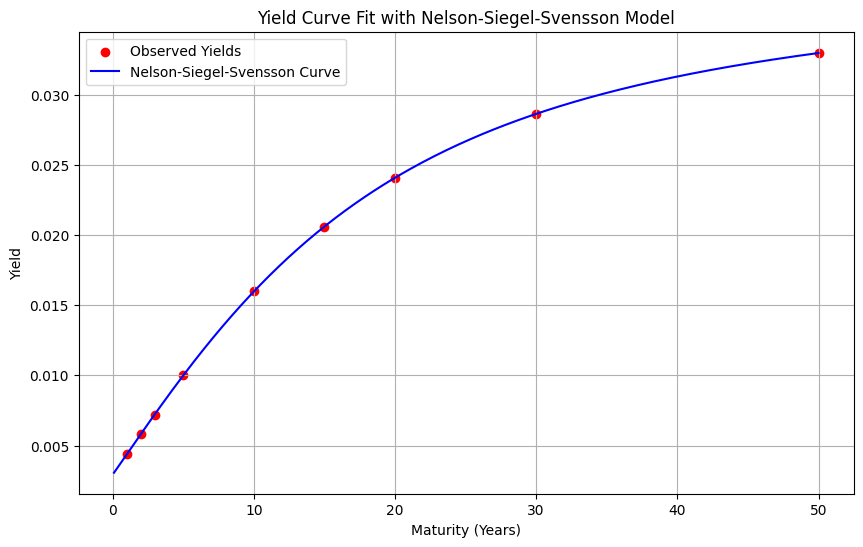

In [39]:
#Plot the observed points and the Nelson-Siegel-Svensson curve fitted to the data.

maturities = np.linspace(0.1, 50, 300)
yields = nss_function(maturities, *popt)

plt.figure(figsize=(10, 6))
plt.scatter(df['Maturity'], df['Yield'], color='red', label='Observed Yields')
plt.plot(maturities, yields, label='Nelson-Siegel-Svensson Curve', color='blue')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.title('Yield Curve Fit with Nelson-Siegel-Svensson Model')
plt.legend()
plt.grid()
plt.show()

In [40]:
#Calculating the yields for each year for the next 50 years
years = range(1, 51)

# Create DataFrame with years and corresponding rates
yields_df = pd.DataFrame({
    'Year': years,
    'Rate': [nss_function(t, *popt) for t in years]
})

yields_df.set_index('Year', inplace=True)
yields_df

,Rate
Year,
1,0.004368
2,0.005816
3,0.007242
4,0.008636
5,0.009988
6,0.011292
7,0.012545
8,0.013743
9,0.014885


In [41]:
#Setting up the bonds dataframe
bonds = pd.DataFrame({
    'Bond': ['A', 'B', 'C'],
    'Value': [10000, 10000, 10000],
    'Coupon': [0, 0.05, 0.07],
    'Maturity': [3, 8, 12]
})

bonds

,Bond,Value,Coupon,Maturity
0,A,10000,0.00,3
1,B,10000,0.05,8
2,C,10000,0.07,12


In [42]:
#Calculating the bonds NPV, Macaulay duration and convexity using the yield curve data.
def calculate_bond_metrics(row, yields_df):
    maturity = row['Maturity']
    face_value = row['Value']
    coupon_rate = row['Coupon']
    
    npv = 0
    macaulay_duration = 0
    convexity = 0
    
    for t in range(1, maturity + 1):
        cash_flow = face_value * coupon_rate if t < maturity else face_value * (1 + coupon_rate)
        discount_rate = yields_df.loc[t, 'Rate']
        
        present_value = cash_flow / (1 + discount_rate) ** t
        npv += present_value
        
        macaulay_duration += t * present_value
        convexity += t * (t + 1) * present_value / (1 + discount_rate)
    
    macaulay_duration /= npv
    convexity /= npv
    
    return pd.Series({'NPV': npv, 'MacaulayDuration': macaulay_duration, 'Convexity': convexity})

metrics = bonds.apply(calculate_bond_metrics, axis=1, yields_df=yields_df)

bonds = pd.concat([bonds, metrics], axis=1)
bonds

,Bond,Value,Coupon,Maturity,NPV,MacaulayDuration,Convexity
0,A,10000,0.00,3,9785.840380,3.000000,11.913717
1,B,10000,0.05,8,12779.689670,6.931948,58.439806
2,C,10000,0.07,12,15771.366658,9.204867,106.053767


In [43]:
#Calculating the same metrics for the liabilites
def calculate_liability_metrics(payments, maturity, yields_df):
    liability_duration = 0
    liability_convexity = 0
    npv_liability = 0

    for t in range(1, maturity + 1):
        cash_flow = payments
        discount_rate = yields_df.loc[t, 'Rate']
        
        # Present value of cash flow
        present_value = cash_flow / (1 + discount_rate) ** t
        npv_liability += present_value

        # Duration and Convexity
        liability_duration += t * present_value
        liability_convexity += t * (t + 1) * present_value / (1 + discount_rate)
    
    # Finalize calculations
    liability_duration /= npv_liability
    liability_convexity /= npv_liability

    return npv_liability, liability_duration, liability_convexity

payments = 100000
liability_maturity = 10

# Calculate liability metrics
npv_liability, liability_duration, liability_convexity = calculate_liability_metrics(
    payments, liability_maturity, yields_df
)

print("Liability NPV:", npv_liability)
print("Liability Duration:", liability_duration)
print("Liability Convexity:", liability_convexity)

Liability NPV: 935718.8596036151
Liability Duration: 5.358571598605133
Liability Convexity: 41.69926779413273


In [44]:
#Portfolio immunization - finding optimal weights for a portfolio of bonds 
bond_npvs = bonds['NPV'].values
bond_durations = bonds['MacaulayDuration'].values
bond_convexities = bonds['Convexity'].values

def objective(weights):
    total_duration = np.dot(weights, bond_durations)
    total_convexity = np.dot(weights, bond_convexities)
    return (total_duration - liability_duration) ** 2 + (total_convexity - liability_convexity) ** 2

# Constraints
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights must be 1
    {'type': 'eq', 'fun': lambda w: np.dot(w, bond_durations) - liability_duration},  # Duration matching
    {'type': 'eq', 'fun': lambda w: np.dot(w, bond_convexities) - liability_convexity}  # Convexity matching
]

bounds = [(0, None) for _ in range(len(bond_npvs))]
initial_weights = [1 / len(bond_npvs)] * len(bond_npvs)
result = minimize(objective, initial_weights, constraints=constraints, bounds=bounds)

if result.success:
    bonds['Weight'] = result.x
else:
    print("Optimization failed:", result.message)
    
bonds

,Bond,Value,Coupon,Maturity,NPV,MacaulayDuration,Convexity,Weight
0,A,10000,0.00,3,9785.840380,3.000000,11.913717,0.452520
1,B,10000,0.05,8,12779.689670,6.931948,58.439806,0.456888
2,C,10000,0.07,12,15771.366658,9.204867,106.053767,0.090592
